<a href="https://colab.research.google.com/github/magistertesis2023/magistertesis2023/blob/main/NEGRO_ACLARADO_Factor_05_998_RED_NEURONAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Cargar dataset de imágenes en memoria**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip /content/drive/MyDrive/mejora.zip -d /content/mejora/
#!unzip /content/drive/MyDrive/dermnet_real.zip -d /content/
#!unzip /content/drive/MyDrive/dermnet_modi.zip -d /content/

#!unzip /content/drive/MyDrive/imagen_244x224.zip -d /content/

#!unzip /content/drive/MyDrive/skin_lesion_m_b.zip -d /content/

!unzip /content/drive/MyDrive/real.zip -d /content/real/
#!unzip /content/drive/MyDrive/real2.zip -d /content/

Defino las rutas de colab de las imagenes

In [ ]:

paths=["/content/drive/MyDrive/MejoraImagenReal/train/",
       "/content/drive/MyDrive/MejoraImagenReal/test/"]

paths=["/content/dermnet_real/train/",
       "/content/dermnet_real/test/"]

paths=["/content/imagen_244x224/train/",
       "/content/imagen_244x224/test/"]

paths=["/content/skin_lesion_m_b/train/",
       "/content/skin_lesion_m_b/test/"]

paths=["/content/real/train/",
       "/content/real/test/"]


Etiquetas=2
baseImagen="ISIC"
epochs_DATA=50
tamano_imagen=224
num_epochs=50


In [ ]:
# https://pypi.python.org/pypi/libarchive
#!apt-get -qq install -y libarchive-dev && pip install -U libarchive
#import libarchive

In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path
from io import BytesIO
from PIL import Image, ImageEnhance
import pandas as pd
import numpy as np
import requests
import random
import glob
import cv2
import os

import math
import scipy
import tensorflow as tf
import tensorflow as tfc
from sklearn import metrics

from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# for Transfer Learning
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import EfficientNetB7

%matplotlib inline

In [ ]:
def imshow(img):
    fig,ax = plt.subplots(1,1,figsize=(8,8))
    ax.imshow(img,cmap='gray')

In [ ]:
possible_labels=os.listdir(paths[1])

In [ ]:
possible_labels

['benign', 'malignant']

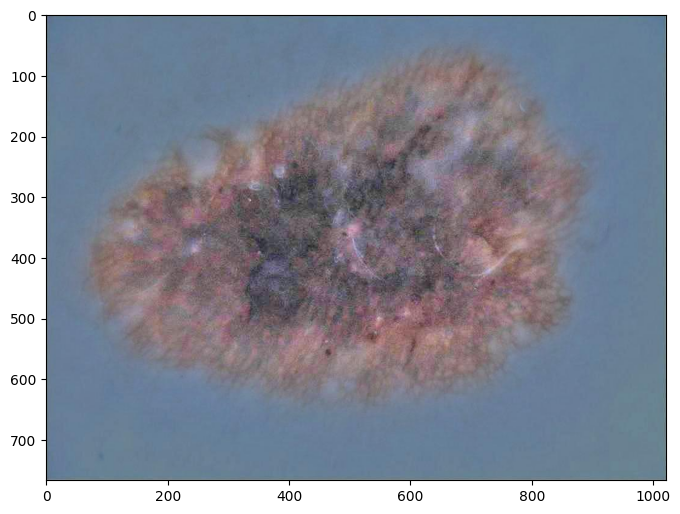

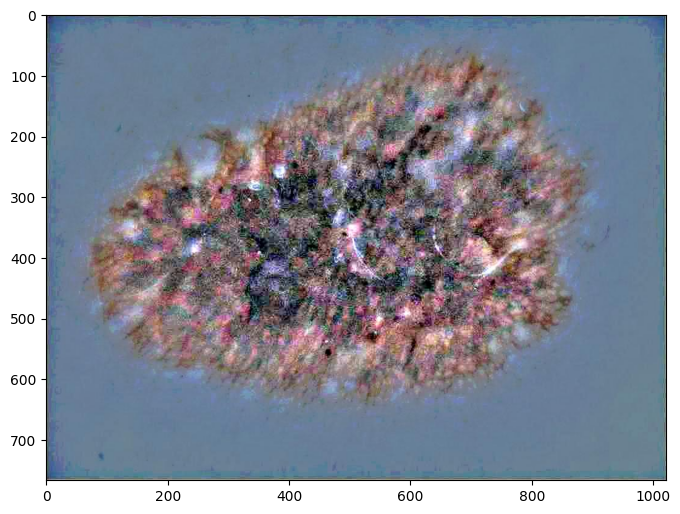

In [ ]:
from PIL import Image, ImageFilter
from PIL import ImageEnhance

photo = Image.open("/content/real/test/benign/ISIC_0000000.jpg")

photo.filter(ImageFilter.GaussianBlur(radius = 20)).save("ISIC_0000000.jpg")
photo.filter(ImageFilter.UnsharpMask(radius = 20,percent = 200,threshold = 5)).save("ISIC_0000000.jpg")

photo_mod = Image.open("ISIC_0000000.jpg")
photo_mod.show()
imshow(photo)
imshow(photo_mod)

In [ ]:
def oscurecer_imagen(imagen_path, factor_oscurecimiento):
    # Abrir la imagen
    imagen = Image.open(imagen_path)
    # Crear un objeto ImageEnhance para oscurecer la imagen
    enhancer = ImageEnhance.Brightness(imagen)
    # Aplicar el factor de oscurecimiento
    imagen_oscurecida = enhancer.enhance(factor_oscurecimiento)
    # Guardar la imagen oscurecida o mostrarla
    #imagen_oscurecida.show()
    # Si prefieres guardar la imagen oscurecida en un archivo, puedes usar:
    # imagen_oscurecida.save("imagen_oscurecida.jpg")
    return imagen_oscurecida

Oscurecer

In [ ]:
data=[]
cuenta=0
for i,path in enumerate(paths):
    for label_int, label_string in enumerate(possible_labels):
        for filename in glob.glob(path+label_string+'/*.jpg'):
            img=cv2.imread(filename)
            factor_oscurecimiento = 1.0
            # Llamar a la función para oscurecer la imagen
            ruta_imagen=filename
            img2=oscurecer_imagen(ruta_imagen, factor_oscurecimiento)
            img2.save(ruta_imagen)
            data.append( [label_int,cv2.resize(img,(tamano_imagen,tamano_imagen))] )
            cuenta=cuenta+1
            if cuenta % 100 == 0: # [+] informa la carga cada 100 imagenes.
              print(cuenta,'images loaded')

len(data)

100 images loaded
200 images loaded
300 images loaded
400 images loaded
500 images loaded
600 images loaded
700 images loaded
800 images loaded
900 images loaded


998

# Aclarar EXCnet metodo S

In [ ]:
import tensorflow.compat.v1 as tf
import tensorflow.compat.v1 as tfc
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

In [ ]:
# Function Definition
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def max_pool_3x3(x):
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

def add_cnn_layer(x, index, weight_shape, bias_shape):
    with tf.name_scope('cnnLayer' + index):
        weights = weight_variable(weight_shape)
        bias = bias_variable(bias_shape)
        conv = tf.nn.conv2d(x, weights, strides=[1, 1, 1, 1], padding='SAME') + bias
        activ = tf.nn.relu(tf.layers.batch_normalization(conv))
        cnn_pool = max_pool_3x3(activ)
    return cnn_pool

def add_fc_layer(x, index, units):
    with tf.name_scope('fcLayer' + index):
        fc = tf.layers.dense(inputs=x, units=units)
        activ = tf.nn.relu(tf.layers.batch_normalization(fc))
    return activ

def alpha_delta(x):
    return tf.multiply(tf.multiply(x, 5), tf.exp(tf.multiply(tf.pow(x, 1.6),-14)))
def alpha(x, phs, phh):
    return tf.subtract(tf.add(x, tf.multiply(phs, alpha_delta(x))), tf.multiply(phh, alpha_delta(1-x)))

def alpha2(x, phs, phh):
    return tf.subtract(tf.add(x, tf.multiply(phs, alpha_delta(x))), tf.multiply(phh * 0.2, alpha_delta(1-x)))

def data_term(res, ori):
    return tf.multiply(tf.sign(tf.subtract(res, 0.5)), tf.subtract(res, ori))

def block_contrast(img, oriSize, padRow, padCol, kernelSize, kernel):
    imgpad = tf.reshape(tf.pad(tf.reshape(img, [oriSize, oriSize]), tf.constant([[padRow, padRow,], [padCol, padCol]]), "SYMMETRIC"),
                        [-1, oriSize + padRow * 2, oriSize + padCol * 2, 1])
    value = kernel
    init = tf.constant_initializer(value)
    return tf.layers.conv2d(imgpad, filters=1, kernel_size=kernelSize, strides=1, padding='VALID',
                     use_bias=False, kernel_initializer=init,
                     trainable=False)
def block_smooth_term(oriImgBlockContrast, newImgBlockContrast):
    return tf.square(tf.subtract(oriImgBlockContrast, newImgBlockContrast))

In [ ]:
# ExCNet Model
blockSize = 4
imgSize = 128
paraSize = imgSize//blockSize

tf.compat.v1.disable_eager_execution()

sess = tf.InteractiveSession()
with tf.name_scope('inputLayer'):
    oriImg = tf.placeholder("float", shape=[None, imgSize, imgSize, 1], name='oriImg')

with tf.name_scope('net'):
    cnn_pool1 = add_cnn_layer(oriImg, '1', [3, 3, 1, 64], [64])

    cnn_pool2 = add_cnn_layer(cnn_pool1, '2', [3, 3, 64, 128], [128])
#     pool2 = max_pool_3x3(conv2)

    cnn_pool3 = add_cnn_layer(cnn_pool2, '3', [3, 3, 128, 256], [256])
#     pool3 = max_pool_3x3(conv3)

    cnn_pool4 = add_cnn_layer(cnn_pool3, '4', [3, 3, 256, 512], [512])
#     pool4 = max_pool_3x3(conv4)

    cnn_pool5 = add_cnn_layer(cnn_pool4, '5', [3, 3, 512, 512], [512])
#     pool5 = max_pool_3x3(conv5)

    pool5_flat = tf.layers.flatten(cnn_pool5)
    with tf.name_scope('fcLayer'):
        fc1 = add_fc_layer(pool5_flat, '1', 512)
        fc2 = add_fc_layer(fc1, '2', 256)
        fc3 = add_fc_layer(fc2, '3', 128)

    with tf.name_scope('paraLayer'):
        paraS = tf.layers.dense(inputs=fc3, units=1)
        paraH = tf.layers.dense(inputs=fc3, units=1)

with tf.name_scope('ouputLayer'):
    newImg = alpha(oriImg, paraS, paraH)

with tf.name_scope('blockLayer'):
    oriImgBlock = tf.nn.avg_pool(oriImg, ksize=[1, blockSize, blockSize, 1], strides=[1, blockSize, blockSize, 1], padding='SAME')
    newImgBlock = tf.nn.avg_pool(newImg, ksize=[1, blockSize, blockSize, 1], strides=[1, blockSize, blockSize, 1], padding='SAME')

with tf.name_scope('dataTerm'):
    Edata = tf.reduce_sum(data_term(newImgBlock, oriImgBlock))

with tf.name_scope('smoothTerm'):
    with tf.name_scope('rightBlock'):
        oriImgBlockContrast_right = block_contrast(oriImgBlock, oriSize=paraSize, padRow=0, padCol=1, kernelSize=[1, 3], kernel=[0, 1, -1])
        newImgBlockContrast_right = block_contrast(newImgBlock, oriSize=paraSize, padRow=0, padCol=1, kernelSize=[1, 3], kernel=[0, 1, -1])
        smoothTerm_right = block_smooth_term(oriImgBlockContrast_right, newImgBlockContrast_right)
    with tf.name_scope('leftBlock'):
        oriImgBlockContrast_left = block_contrast(oriImgBlock, oriSize=paraSize, padRow=0, padCol=1, kernelSize=[1, 3], kernel=[-1, 1, 0])
        newImgBlockContrast_left = block_contrast(newImgBlock, oriSize=paraSize, padRow=0, padCol=1, kernelSize=[1, 3], kernel=[-1, 1, 0])
        smoothTerm_left = block_smooth_term(oriImgBlockContrast_left, newImgBlockContrast_left)
    with tf.name_scope('upBlock'):
        oriImgBlockContrast_up = block_contrast(oriImgBlock, oriSize=paraSize, padRow=1, padCol=0, kernelSize=[3, 1], kernel=[-1, 1, 0])
        newImgBlockContrast_up = block_contrast(newImgBlock, oriSize=paraSize, padRow=1, padCol=0, kernelSize=[3, 1], kernel=[-1, 1, 0])
        smoothTerm_up = block_smooth_term(oriImgBlockContrast_up, newImgBlockContrast_up)
    with tf.name_scope('downBlock'):
        oriImgBlockContrast_down = block_contrast(oriImgBlock, oriSize=paraSize, padRow=1, padCol=0, kernelSize=[3, 1], kernel=[0, 1, -1])
        newImgBlockContrast_down = block_contrast(newImgBlock, oriSize=paraSize, padRow=1, padCol=0, kernelSize=[3, 1], kernel=[0, 1, -1])
        smoothTerm_down = block_smooth_term(oriImgBlockContrast_down, newImgBlockContrast_down)
    Esmooth = tf.reduce_sum(0.5 * tf.add(tf.add(smoothTerm_right, smoothTerm_left), tf.add(smoothTerm_up, smoothTerm_down)))

with tf.name_scope('energyFunction'):
    En = Edata + 12 * Esmooth

<ipython-input-13-e019dd74a91f>:18: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  activ = tf.nn.relu(tf.layers.batch_normalization(conv))
<ipython-input-14-00f874eee373>:27: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  pool5_flat = tf.layers.flatten(cnn_pool5)
<ipython-input-13-e019dd74a91f>:24: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  fc = tf.layers.dense(inputs=x, units=units)
<ipython-input-13-e019dd74a91f>:25: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNor

In [ ]:
def alpha_delta_numpy(x):
    return x * 5 * np.exp((x ** 1.6) * -14)
def alpha_numpy(x, phs, phh):
    return x + phs * alpha_delta_numpy(x) - phh * 0.2 * alpha_delta_numpy(1-x)

In [ ]:
train_step = tf.train.AdamOptimizer(0.001).minimize(En)
sess.run(tf.global_variables_initializer())
# saver = tf.train.Saver()

In [ ]:
# Input Preprocessing
image = cv2.imread('/content/real/train/malignant/ISIC_0000156.jpg')
height, width, channel = image.shape
B = image[:,:,0]
G = image[:,:,1]
R = image[:,:,2]
Y = 0.299 * R + 0.587 * G + 0.114 * B
I = 0.596 * R - 0.274 * G - 0.322 * B
Q = 0.211 * R - 0.523 * G + 0.312 * B
base_layer = cv2.ximgproc.guidedFilter(Y.astype('uint8'), Y.astype('uint8'),
                                       int(0.04*min(height, width)), 800)
# ori_base = tf.reshape(base_layer/255, [1, height, width, 1])
# resize_base = tf.image.resize_images(ori_base, [imgSize, imgSize])
# imgV = resize_base.eval()
imgR = cv2.resize(base_layer/255, (imgSize, imgSize))
imgV = np.zeros((1, imgSize, imgSize, 1))
imgV[0,:,:,0] = imgR

In [ ]:
# Model Iteration
for i in range(1000):
    train_step.run(feed_dict={oriImg: imgV})
    if i%200 == 0:
        loss = En.eval(feed_dict={oriImg: imgV})
        phS = paraS.eval(feed_dict={oriImg: imgV})
        phH = paraH.eval(feed_dict={oriImg: imgV})
#         log = sess.run(merged_summary_op, feed_dict={oriImg: imgV})
#         summary_writer.add_summary(log, i)
#         saver.save(sess,'model/model.ckpt')
        print("train_loss %f"%loss)
        print("phS %f"%phS)
        print("phH %f"%phH)

train_loss 1041566.312500
phS -218.195389
phH 18.877283
train_loss 10.591677
phS 0.966004
phH -4.920738
train_loss -42.042221
phS 0.903661
phH -6.632489
train_loss -4.148571
phS 0.922421
phH -6.684243
train_loss -13.907210
phS 0.918011
phH -6.701911


In [ ]:
# Image Postprocessing
new_base = alpha_numpy(base_layer/255, np.float64(phS), np.float64(phH))
ratio = new_base/(base_layer/255+0.00001)

In [ ]:
newY = ratio * Y
newI = ratio * I
newQ = ratio * Q
# newR = 1. * newY + 0.956 * newI + 0.621 * newQ
# newG = 1. * newY - 0.272 * newI - 0.647 * newQ
# newB = 1. * newY - 1.106 * newI + 1.703 * newQ
newR = (1. * newY + 0.956 * newI + 0.621 * newQ)+0
newG = (1. * newY - 0.272 * newI - 0.647 * newQ)+0
newB = (1. * newY - 1.106 * newI + 1.703 * newQ)+0
newR[newR<0]=0
newG[newG<0]=0
newB[newB<0]=0
newR[newR>255]=255
newG[newG>255]=255
newB[newB>255]=255
result = image.copy()
result[:,:,0] = newB
result[:,:,1] = newG
result[:,:,2] = newR
cv2.imwrite('ISIC_0000156.jpg',result)

True

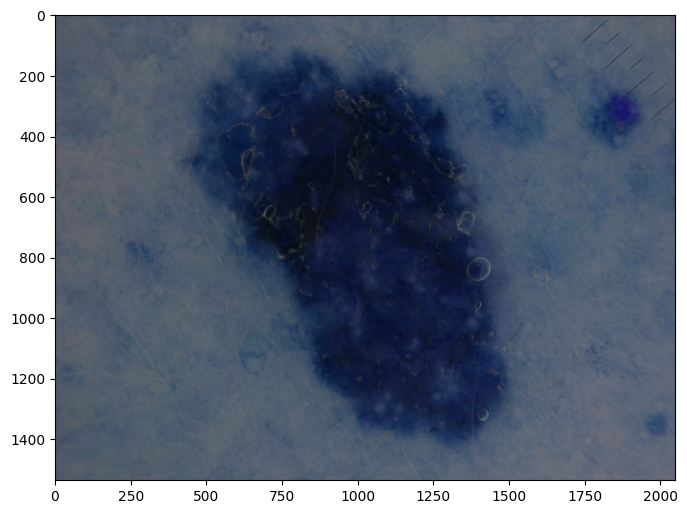

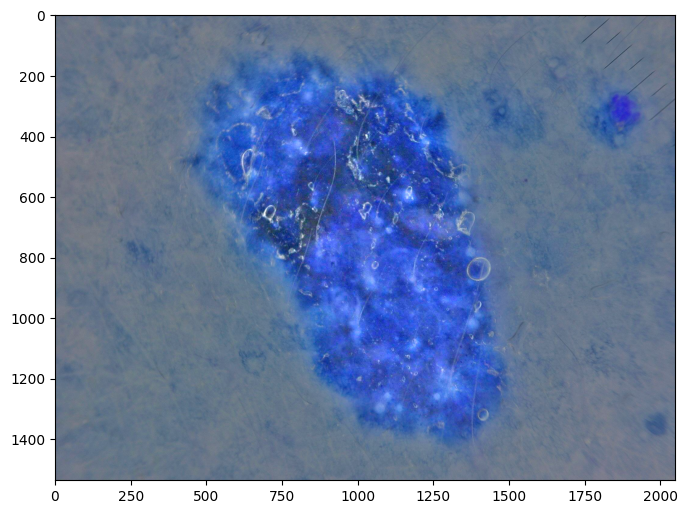

In [ ]:
imshow(image)
imshow(result)

#  metodo cambio Exnet - test

In [ ]:
#  Batch Test: Read folder images
path = '/content/real/test/'
savePath = '/content/real/test/'
groupList = ['benign/', 'malignant/']
imgV = np.zeros((1, imgSize, imgSize, 1))
for groupInd in range(1):
    readPath = path+groupList[groupInd]
    for filename in os.listdir(readPath):
        print("image: %s"%readPath+filename)

        image = cv2.imread(readPath+filename)
        height, width, channel = image.shape
        B = image[:,:,0]
        G = image[:,:,1]
        R = image[:,:,2]
        Y = 0.299 * R + 0.587 * G + 0.114 * B
        I = 0.596 * R - 0.274 * G - 0.322 * B
        Q = 0.211 * R - 0.523 * G + 0.312 * B
        base_layer = cv2.ximgproc.guidedFilter(Y.astype('uint8'), Y.astype('uint8'),
                                               int(0.04*min(height, width)), 800)
        imgR = cv2.resize(base_layer/255, (imgSize, imgSize))
        imgV[0,:,:,0] = imgR

        for i in range(1000):
            train_step.run(feed_dict={oriImg: imgV})
            if i%200 == 0:
                loss = En.eval(feed_dict={oriImg: imgV})
                phS = paraS.eval(feed_dict={oriImg: imgV})
                phH = paraH.eval(feed_dict={oriImg: imgV})
                print("train_loss: %f"%loss)
                print("phS: %f"%phS)
                print("phH: %f"%phH)

        new_base = alpha_numpy(base_layer/255, np.float64(phS), np.float64(phH))
        ratio = new_base/(base_layer/255+0.00001)

        newY = ratio * Y
        newI = ratio * I
        newQ = ratio * Q
        newR = (1. * newY + 0.956 * newI + 0.621 * newQ)+0
        newG = (1. * newY - 0.272 * newI - 0.647 * newQ)+0
        newB = (1. * newY - 1.106 * newI + 1.703 * newQ)+0
        newR[newR<0]=0
        newG[newG<0]=0
        newB[newB<0]=0
        newR[newR>255]=255
        newG[newG>255]=255
        newB[newB>255]=255
        result = image.copy()
        result[:,:,0] = newB
        result[:,:,1] = newG
        result[:,:,2] = newR
        cv2.imwrite(savePath+groupList[groupInd]+filename,result)

#  metodo cambio Exnet - train

In [ ]:
#  Batch Test: Read folder images
path = '/content/real/train/'
savePath = '/content/real/train/'
groupList = ['benign/', 'malignant/']
imgV = np.zeros((1, imgSize, imgSize, 1))
for groupInd in range(1):
    readPath = path+groupList[groupInd]
    for filename in os.listdir(readPath):
        print("image: %s"%readPath+filename)

        image = cv2.imread(readPath+filename)
        height, width, channel = image.shape
        B = image[:,:,0]
        G = image[:,:,1]
        R = image[:,:,2]
        Y = 0.299 * R + 0.587 * G + 0.114 * B
        I = 0.596 * R - 0.274 * G - 0.322 * B
        Q = 0.211 * R - 0.523 * G + 0.312 * B
        base_layer = cv2.ximgproc.guidedFilter(Y.astype('uint8'), Y.astype('uint8'),
                                               int(0.04*min(height, width)), 800)
        imgR = cv2.resize(base_layer/255, (imgSize, imgSize))
        imgV[0,:,:,0] = imgR

        for i in range(1000):
            train_step.run(feed_dict={oriImg: imgV})
            if i%200 == 0:
                loss = En.eval(feed_dict={oriImg: imgV})
                phS = paraS.eval(feed_dict={oriImg: imgV})
                phH = paraH.eval(feed_dict={oriImg: imgV})
                print("train_loss: %f"%loss)
                print("phS: %f"%phS)
                print("phH: %f"%phH)

        new_base = alpha_numpy(base_layer/255, np.float64(phS), np.float64(phH))
        ratio = new_base/(base_layer/255+0.00001)

        newY = ratio * Y
        newI = ratio * I
        newQ = ratio * Q
        newR = (1. * newY + 0.956 * newI + 0.621 * newQ)+0
        newG = (1. * newY - 0.272 * newI - 0.647 * newQ)+0
        newB = (1. * newY - 1.106 * newI + 1.703 * newQ)+0
        newR[newR<0]=0
        newG[newG<0]=0
        newB[newB<0]=0
        newR[newR>255]=255
        newG[newG>255]=255
        newB[newB>255]=255
        result = image.copy()
        result[:,:,0] = newB
        result[:,:,1] = newG
        result[:,:,2] = newR
        cv2.imwrite(savePath+groupList[groupInd]+filename,result)

In [ ]:
import random
random.Random(0).shuffle(data)

x_train=[]
y_train=[]

x_val=[]
y_val=[]

x_test=[]
y_test=[]

for i, sample in enumerate(data):
    label=sample[0]
    img=sample[1]
    if i<= 0.7*len(data):
        x_train.append(img)
        y_train.append(label)
    elif i>0.8*len(data) and i<=0.9*len(data):
        x_val.append(img)
        y_val.append(label)
    else:
        x_test.append(img)
        y_test.append(label)

x_train=np.array(x_train)
x_val=np.array(x_val)
x_test=np.array(x_test)

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [ ]:
x_test.shape

(199, 224, 224, 3)

In [ ]:
x_train.shape

(699, 224, 224, 3)

In [ ]:
x_train.shape

(699, 224, 224, 3)

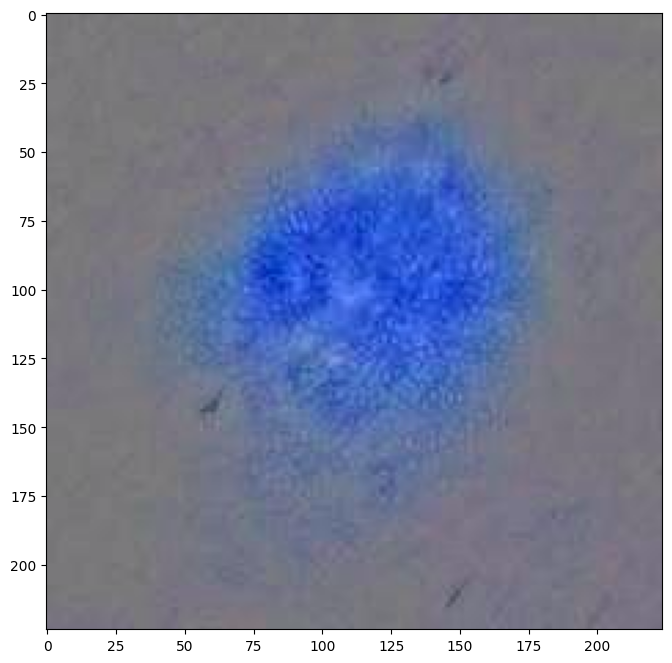

In [ ]:
imshow(x_train[0])

In [ ]:
y_train[0]

0

In [ ]:
possible_labels[y_train[0]]

'benign'

In [ ]:
train_data_path = '/content/real/train'  #path[0] #'/content/imagen_244x224/train'
validation_data_path = '/content/real/test' #path[1] #'/content/imagen_244x224/test'
#train_data_path = '/content/imagen_244x224/train'
#validation_data_path = '/content/imagen_244x224/test'
#train_data_path = '/content/skin_lesion_m_b/train'
#validation_data_path = '/content/skin_lesion_m_b/test'

imagen_dematologica = os.listdir(train_data_path)
img_width, img_height = tamano_imagen, tamano_imagen
batch_size = 32

print("Number of Categories:", len(imagen_dematologica))
print("Categories: ", imagen_dematologica)

Number of Categories: 2
Categories:  ['benign', 'malignant']


In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 0,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rotation_range = 0,rescale=1. / 255,zoom_range=0.2,shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 868 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


# Definición y entrenamiento de la red

In [ ]:
def plot_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    #epochs = len(history.history['acc'])
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    #axs[0].plot(history.history['step'])
    axs[0].set_title('Model Accuracy - Precisión')
    axs[0].set_ylabel('Accuracy - Precisión')
    axs[0].set_xlabel('Epoch - Epoca')
    axs[0].legend(['train', 'validate'], loc='upper left')

    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss -  Costo')
    axs[1].set_ylabel('Loss - Costo')
    axs[1].set_xlabel('Epoch - Epoca')
    axs[1].legend(['train', 'validate'], loc='upper left')

    plt.show()

# history = pd.read_csv(TRAINING_LOG_PATH, sep=',', engine='python')
#plot_history(history)

# RestNet50

In [ ]:
model_base = ResNet50(weights='imagenet',include_top=False)

x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
Resnet50_model = models.Model(inputs= model_base.input, outputs=predictions)


In [ ]:
Resnet50_model.compile(loss='categorical_crossentropy',
                       optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                       metrics=['accuracy'])

In [ ]:
historyResnet50 = Resnet50_model.fit(train_generator,
                                               epochs=num_epochs,
                                               shuffle=True, verbose=1,
                                               validation_data=validation_generator)

<ipython-input-23-69f1be779310>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyResnet50 = Resnet50_model.fit_generator(train_generator,


Epoch 1/50
28/28 [==============================] - 34s 559ms/step - loss: 0.0463 - accuracy: 0.9862 - val_loss: 4.5909 - val_accuracy: 0.3077
Epoch 2/50
28/28 [==============================] - 14s 481ms/step - loss: 1.3065e-04 - accuracy: 1.0000 - val_loss: 1.1070 - val_accuracy: 0.3077
Epoch 3/50
28/28 [==============================] - 14s 484ms/step - loss: 0.0019 - accuracy: 0.9988 - val_loss: 0.6139 - val_accuracy: 0.6923
Epoch 4/50
28/28 [==============================] - 14s 481ms/step - loss: 0.0132 - accuracy: 0.9942 - val_loss: 1.1263 - val_accuracy: 0.3077
Epoch 5/50
28/28 [==============================] - 14s 491ms/step - loss: 0.0267 - accuracy: 0.9896 - val_loss: 63.9888 - val_accuracy: 0.6923
Epoch 6/50
28/28 [==============================] - 14s 481ms/step - loss: 0.0698 - accuracy: 0.9850 - val_loss: 0.8614 - val_accuracy: 0.3077
Epoch 7/50
28/28 [==============================] - 14s 484ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 4.0232 - val_accuracy: 0

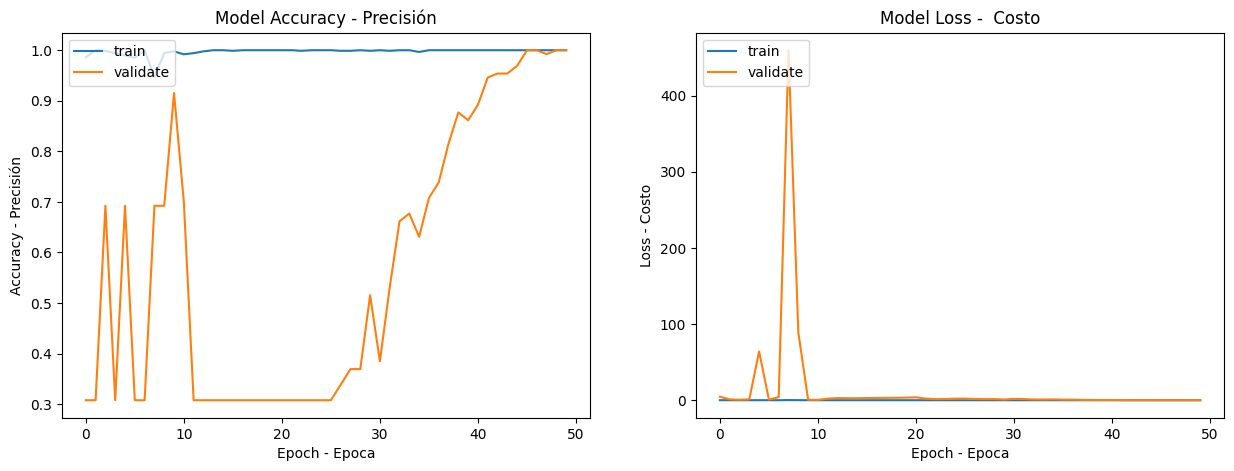

In [ ]:
plot_history(historyResnet50)

In [ ]:
# Evaluar el modelo
lossResnet50, accuracyResnet50 = Resnet50_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss Resnet50:', lossResnet50)
print('Accuracy Resnet50:', accuracyResnet50)

5/5 [==============================] - 2s 389ms/step - loss: 0.0029 - accuracy: 1.0000
Loss Resnet50: 0.0028510543052107096
Accuracy Resnet50: 1.0


In [ ]:
model_base.save('/content/drive/MyDrive/modelos/isic/aclarado_S_224x224_Resnet50.keras')

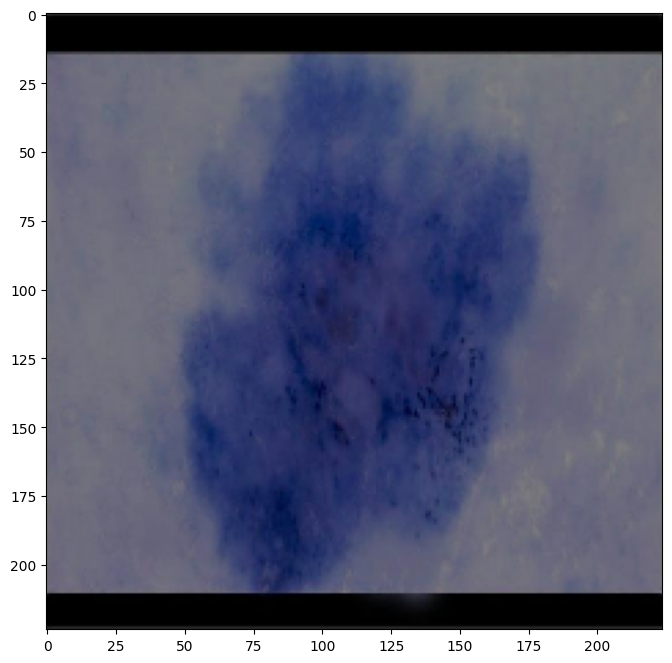

In [ ]:
import matplotlib.pyplot as plt
imshow(img)

# Mobilenet


In [ ]:
model_base = MobileNet(weights='imagenet',include_top=False)

x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
MobileNet_model = models.Model(inputs= model_base.input, outputs=predictions)


In [ ]:
MobileNet_model.compile(loss='categorical_crossentropy',
                        optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                        metrics=['accuracy'])

In [ ]:
hist_mobile = MobileNet_model.fit(train_generator,
                                            epochs=num_epochs,
                                            shuffle=True,
                                            verbose=1,
                                            validation_data=validation_generator)

<ipython-input-22-bab7a8e148ce>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist_mobile = MobileNet_model.fit_generator(train_generator,


Epoch 1/50
28/28 [==============================] - 23s 516ms/step - loss: 0.0538 - accuracy: 0.9804 - val_loss: 0.0591 - val_accuracy: 0.9769
Epoch 2/50
28/28 [==============================] - 13s 480ms/step - loss: 0.0027 - accuracy: 0.9988 - val_loss: 0.0967 - val_accuracy: 0.9769
Epoch 3/50
28/28 [==============================] - 13s 469ms/step - loss: 0.0516 - accuracy: 0.9862 - val_loss: 0.0904 - val_accuracy: 0.9846
Epoch 4/50
28/28 [==============================] - 13s 465ms/step - loss: 0.0362 - accuracy: 0.9908 - val_loss: 2.5095 - val_accuracy: 0.3692
Epoch 5/50
28/28 [==============================] - 14s 479ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 1.2939 - val_accuracy: 0.6154
Epoch 6/50
28/28 [==============================] - 13s 471ms/step - loss: 9.0397e-04 - accuracy: 1.0000 - val_loss: 0.2079 - val_accuracy: 0.9077
Epoch 7/50
28/28 [==============================] - 13s 473ms/step - loss: 1.2700e-04 - accuracy: 1.0000 - val_loss: 0.0453 - val_accuracy

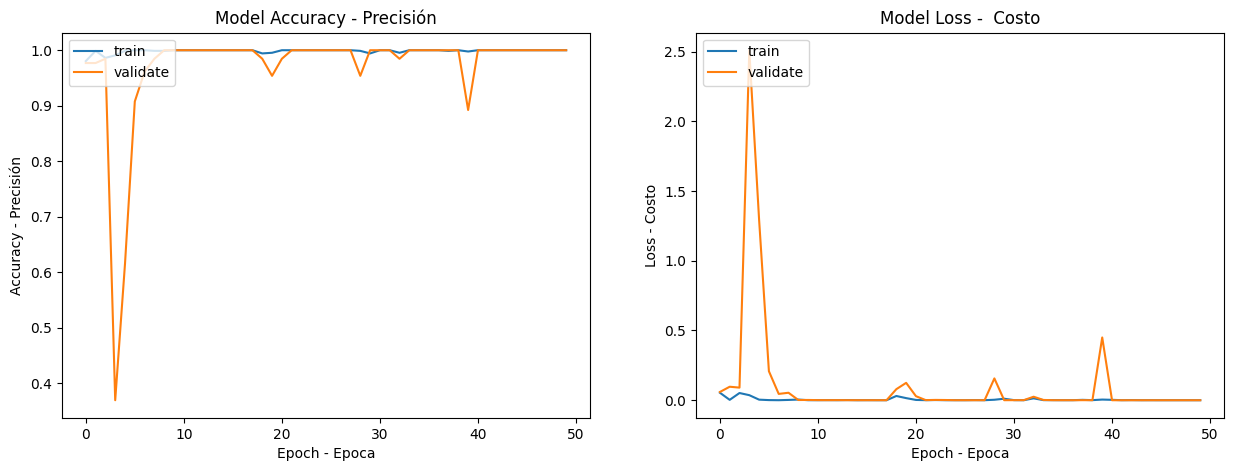

In [ ]:
plot_history(hist_mobile)

In [ ]:
# Evaluar el modelo
lossMobileNet, accuracyMobileNet = MobileNet_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss mobilenet:', lossMobileNet)
print('Accuracy mobilenet:', accuracyMobileNet)

5/5 [==============================] - 2s 404ms/step - loss: 1.0272e-05 - accuracy: 1.0000
Loss mobilenet: 1.0271817700413521e-05
Accuracy mobilenet: 1.0


In [ ]:
model_base.save('/content/drive/MyDrive/modelos/isic/aclarado_S__224x224_mobilenet.keras')

# Xception

In [ ]:
Xception_base = Xception(weights='imagenet', include_top=False)

x = Xception_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())), activation='softmax')(x)
Xception_transfer = models.Model(inputs=Xception_base.input, outputs=predictions)

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
Xception_transfer.compile(loss='categorical_crossentropy',
                          optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                          metrics=['accuracy'])

In [ ]:
historyXception = Xception_transfer.fit(train_generator,
                                                  epochs=num_epochs,
                                                  shuffle = True,
                                                  verbose = 1,
                                                  validation_data = validation_generator)

<ipython-input-22-a4fc43f0d71f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyXception = Xception_transfer.fit_generator(train_generator,


Epoch 1/50
28/28 [==============================] - 34s 624ms/step - loss: 0.2638 - accuracy: 0.8214 - val_loss: 0.6115 - val_accuracy: 0.6923
Epoch 2/50
28/28 [==============================] - 15s 528ms/step - loss: 0.0995 - accuracy: 0.9447 - val_loss: 0.4536 - val_accuracy: 0.7615
Epoch 3/50
28/28 [==============================] - 15s 535ms/step - loss: 0.0513 - accuracy: 0.9977 - val_loss: 0.2785 - val_accuracy: 0.9000
Epoch 4/50
28/28 [==============================] - 15s 569ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.1151 - val_accuracy: 0.9462
Epoch 5/50
28/28 [==============================] - 16s 546ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0976 - val_accuracy: 0.9462
Epoch 6/50
28/28 [==============================] - 16s 543ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0613 - val_accuracy: 0.9769
Epoch 7/50
28/28 [==============================] - 15s 537ms/step - loss: 0.0344 - accuracy: 0.9896 - val_loss: 0.0767 - val_accuracy: 0.9846

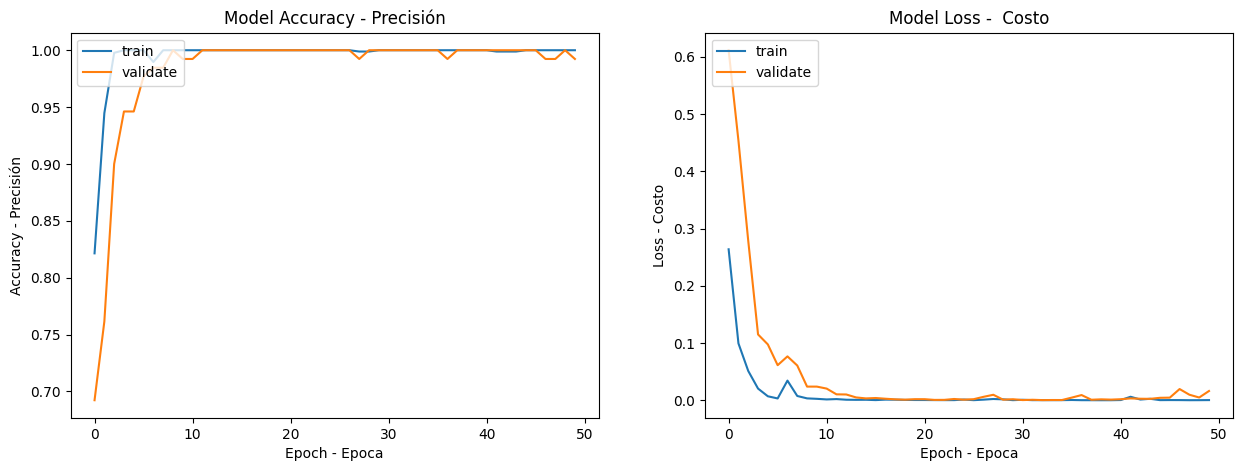

In [ ]:
plot_history(historyXception)

In [ ]:
# Evaluar el modelo
lossXception, accuracyXception = Xception_transfer.evaluate(validation_generator, steps=len(validation_generator))
print('Loss Xception:', lossXception)
print('Accuracy Xception:', accuracyXception)

5/5 [==============================] - 2s 388ms/step - loss: 0.0013 - accuracy: 1.0000
Loss Xception: 0.0013107771519571543
Accuracy Xception: 1.0


In [ ]:
Xception_base.save('/content/drive/MyDrive/modelos/isic/aclarado_S_224x224_Xception.keras')

# InceptionV3

In [ ]:
model_base = InceptionV3(weights='imagenet',include_top=False)

x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
InceptionV3_model = models.Model(inputs= model_base.input, outputs=predictions)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
InceptionV3_model.compile(loss='categorical_crossentropy',
                          optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                          metrics=['accuracy'])

In [ ]:
historyInceptionV3 = InceptionV3_model.fit(train_generator,
                                                     epochs=num_epochs,
                                                     shuffle=True,
                                                     verbose=1,
                                                     validation_data=validation_generator)

<ipython-input-22-52f6bca92e93>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyInceptionV3 = InceptionV3_model.fit_generator(train_generator,


Epoch 1/50
28/28 [==============================] - 37s 591ms/step - loss: 0.1102 - accuracy: 0.9551 - val_loss: 1.4200 - val_accuracy: 0.6615
Epoch 2/50
28/28 [==============================] - 14s 488ms/step - loss: 0.0057 - accuracy: 0.9988 - val_loss: 1.5668 - val_accuracy: 0.7077
Epoch 3/50
28/28 [==============================] - 14s 484ms/step - loss: 0.0033 - accuracy: 0.9977 - val_loss: 1.1589 - val_accuracy: 0.8154
Epoch 4/50
28/28 [==============================] - 14s 482ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3049 - val_accuracy: 0.8923
Epoch 5/50
28/28 [==============================] - 14s 481ms/step - loss: 0.0062 - accuracy: 0.9977 - val_loss: 0.6923 - val_accuracy: 0.8308
Epoch 6/50
28/28 [==============================] - 14s 479ms/step - loss: 0.0116 - accuracy: 0.9965 - val_loss: 0.7948 - val_accuracy: 0.8462
Epoch 7/50
28/28 [==============================] - 14s 482ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1570 - val_accuracy: 0.9385

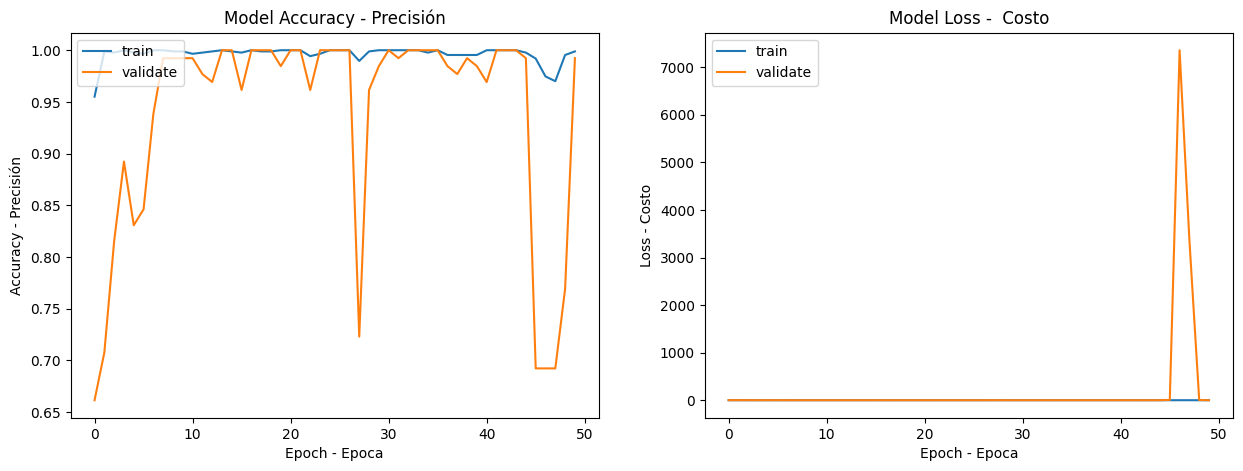

In [ ]:
plot_history(historyInceptionV3)

In [ ]:
# Evaluar el modelo
lossInceptionV3, accuracyInceptionV3 = InceptionV3_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss InceptionV3:', lossInceptionV3)
print('Accuracy InceptionV3:', accuracyInceptionV3)

5/5 [==============================] - 2s 372ms/step - loss: 0.0073 - accuracy: 1.0000
Loss InceptionV3: 0.007272210903465748
Accuracy InceptionV3: 1.0


In [ ]:
InceptionV3_model.save('/content/drive/MyDrive/modelos/isic/aclarado_S_224x224_InceptionV3.keras')

# VGG-16

In [ ]:
model_base = VGG16(weights='imagenet',include_top=False)

x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
Vgg16_model = models.Model(inputs= model_base.input, outputs=predictions)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
Vgg16_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                    metrics=['accuracy'])

In [ ]:
historyVgg16 = Vgg16_model.fit(train_generator,
                                         epochs=num_epochs,
                                         shuffle=True,
                                         verbose=1,
                                         validation_data=validation_generator)

<ipython-input-30-f562d1a58787>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyVgg16 = Vgg16_model.fit_generator(train_generator,


Epoch 1/50
28/28 [==============================] - 20s 540ms/step - loss: 0.4333 - accuracy: 0.8618 - val_loss: 0.7164 - val_accuracy: 0.6923
Epoch 2/50
28/28 [==============================] - 15s 515ms/step - loss: 0.4338 - accuracy: 0.8629 - val_loss: 0.9379 - val_accuracy: 0.6923
Epoch 3/50
28/28 [==============================] - 14s 515ms/step - loss: 0.4139 - accuracy: 0.8664 - val_loss: 0.8976 - val_accuracy: 0.6923
Epoch 4/50
28/28 [==============================] - 15s 546ms/step - loss: 0.4454 - accuracy: 0.8594 - val_loss: 0.7249 - val_accuracy: 0.6923
Epoch 5/50
28/28 [==============================] - 15s 521ms/step - loss: 0.4809 - accuracy: 0.8306 - val_loss: 0.6125 - val_accuracy: 0.6923
Epoch 6/50
28/28 [==============================] - 15s 519ms/step - loss: 0.4227 - accuracy: 0.8629 - val_loss: 0.6935 - val_accuracy: 0.6923
Epoch 7/50
28/28 [==============================] - 15s 520ms/step - loss: 0.4735 - accuracy: 0.8387 - val_loss: 0.6212 - val_accuracy: 0.6923

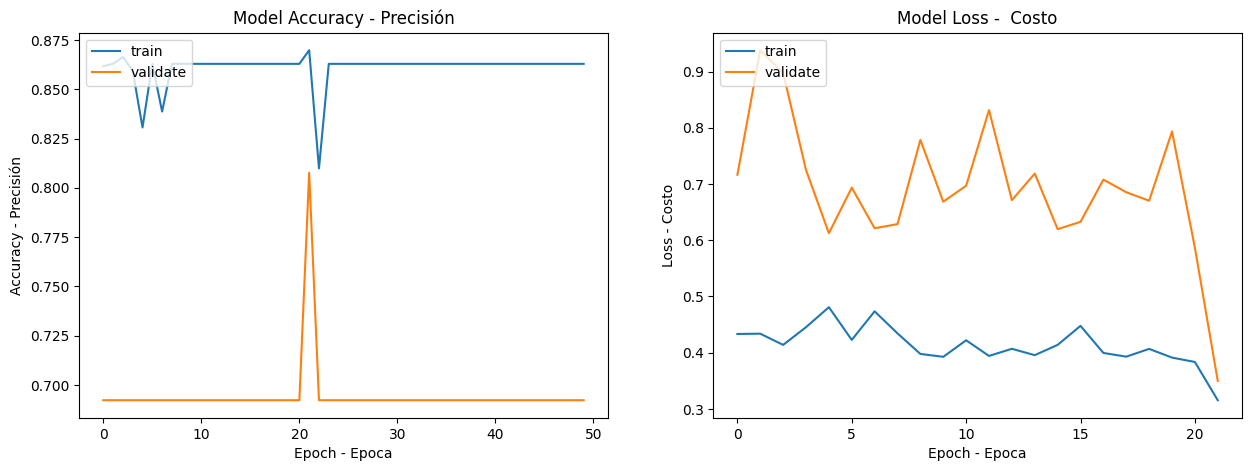

In [ ]:
plot_history(historyVgg16)

In [ ]:
# Evaluar el modelo
lossVgg16, accuracyVgg16 = Vgg16_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss Vgg16:', lossVgg16)
print('Accuracy Vgg16:', accuracyVgg16)

5/5 [==============================] - 2s 458ms/step - loss: nan - accuracy: 0.6923
Loss Vgg16: nan
Accuracy Vgg16: 0.692307710647583


In [ ]:
Vgg16_model.save('/content/drive/MyDrive/modelos/isic/aclarado_S_224x224_Vgg16.keras')

# VGG-19

In [ ]:
model_base = VGG19(weights='imagenet',include_top=False)

x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
Vgg19_model = models.Model(inputs= model_base.input, outputs=predictions)

80134624/80134624 [==============================] - 5s 0us/step


In [ ]:
Vgg19_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                    metrics=['accuracy'])

In [ ]:
historyVgg19 = Vgg19_model.fit(train_generator,
                                         epochs=num_epochs,
                                         shuffle=True,
                                         verbose=1,
                                         validation_data=validation_generator)

<ipython-input-36-cc323d7b8028>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyVgg19 = Vgg19_model.fit_generator(train_generator,


Epoch 1/50
28/28 [==============================] - 17s 530ms/step - loss: 0.4230 - accuracy: 0.8629 - val_loss: 0.7963 - val_accuracy: 0.6923
Epoch 2/50
28/28 [==============================] - 15s 525ms/step - loss: 0.4370 - accuracy: 0.8629 - val_loss: 1.2039 - val_accuracy: 0.6923
Epoch 3/50
28/28 [==============================] - 15s 522ms/step - loss: 0.4504 - accuracy: 0.8641 - val_loss: 0.7818 - val_accuracy: 0.6923
Epoch 4/50
28/28 [==============================] - 15s 518ms/step - loss: 0.4046 - accuracy: 0.8629 - val_loss: 0.8403 - val_accuracy: 0.6923
Epoch 5/50
28/28 [==============================] - 15s 517ms/step - loss: nan - accuracy: 0.7154 - val_loss: nan - val_accuracy: 0.6923
Epoch 6/50
28/28 [==============================] - 14s 519ms/step - loss: nan - accuracy: 0.8629 - val_loss: nan - val_accuracy: 0.6923
Epoch 7/50
28/28 [==============================] - 14s 513ms/step - loss: nan - accuracy: 0.8629 - val_loss: nan - val_accuracy: 0.6923
Epoch 8/50
28/28 

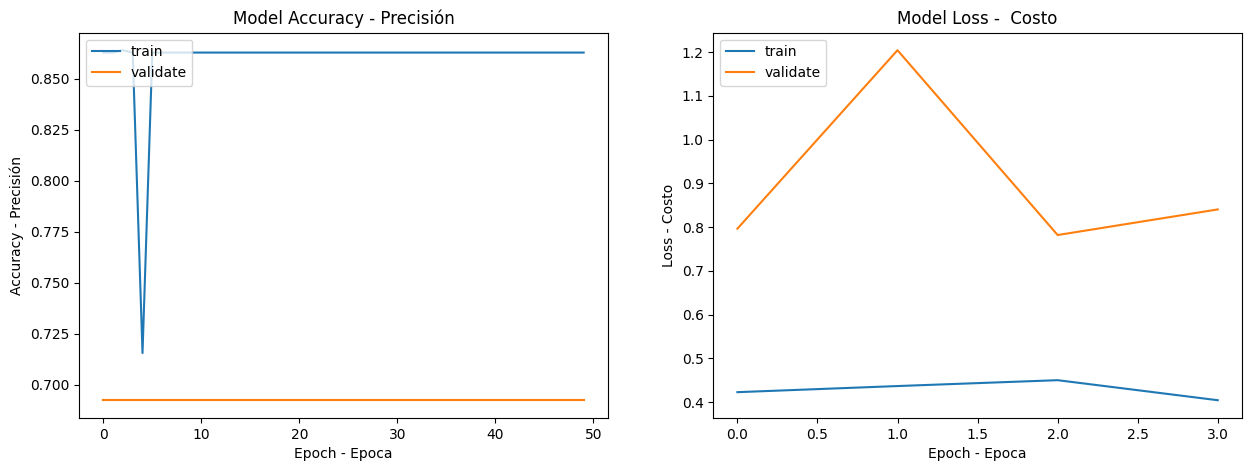

In [ ]:
plot_history(historyVgg19)

In [ ]:
# Evaluar el modelo
lossVgg19, accuracyVgg19 = Vgg19_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss Vgg19:', lossVgg19)
print('Accuracy Vgg19:', accuracyVgg19)

5/5 [==============================] - 2s 439ms/step - loss: nan - accuracy: 0.6923
Loss Vgg19: nan
Accuracy Vgg19: 0.692307710647583


In [ ]:
Vgg19_model.save('/content/drive/MyDrive/modelos/isic/aclarado_S_224x224_Vgg19.keras')

# EfficientNet

In [ ]:
model_base = EfficientNetB7(weights='imagenet',include_top=False)
x = model_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512,activation='relu')(x)
predictions = layers.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
EfficientNetB7_model = models.Model(inputs= model_base.input, outputs=predictions)

258076736/258076736 [==============================] - 12s 0us/step


In [ ]:
EfficientNetB7_model.compile(loss='categorical_crossentropy',
                             optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9) ,
                             metrics=['accuracy'])

In [ ]:
historyEfficientNet = EfficientNetB7_model.fit(train_generator,
                                                         epochs=num_epochs,
                                                         shuffle=True,
                                                         verbose=1,
                                                         validation_data=validation_generator)

<ipython-input-23-fb2e43d17e8d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyEfficientNet = EfficientNetB7_model.fit_generator(train_generator,


Epoch 1/50
28/28 [==============================] - 104s 732ms/step - loss: 0.2722 - accuracy: 0.8986 - val_loss: 1.4636 - val_accuracy: 0.6923
Epoch 2/50
28/28 [==============================] - 15s 534ms/step - loss: 0.0330 - accuracy: 0.9965 - val_loss: 2.0661 - val_accuracy: 0.6923
Epoch 3/50
28/28 [==============================] - 15s 533ms/step - loss: 0.0132 - accuracy: 0.9988 - val_loss: 2.4490 - val_accuracy: 0.6923
Epoch 4/50
28/28 [==============================] - 15s 539ms/step - loss: 0.0179 - accuracy: 0.9954 - val_loss: 1.5658 - val_accuracy: 0.6923
Epoch 5/50
28/28 [==============================] - 15s 534ms/step - loss: 0.0246 - accuracy: 0.9896 - val_loss: 2.6884 - val_accuracy: 0.6923
Epoch 6/50
28/28 [==============================] - 15s 538ms/step - loss: 0.0109 - accuracy: 0.9977 - val_loss: 2.3038 - val_accuracy: 0.6923
Epoch 7/50
28/28 [==============================] - 15s 537ms/step - loss: 0.0059 - accuracy: 0.9988 - val_loss: 2.4840 - val_accuracy: 0.692

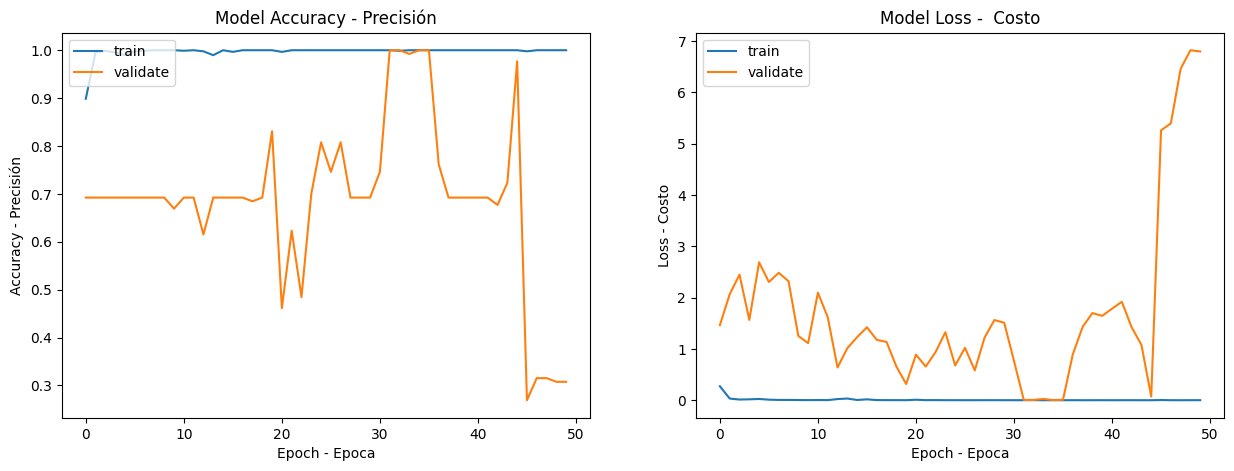

In [ ]:
plot_history(historyEfficientNet)

In [ ]:
# Evaluar el modelo
lossEfficientNetB7, accuracyEfficientNetB7 = EfficientNetB7_model.evaluate(validation_generator, steps=len(validation_generator))
print('Loss EfficientNetB7:', lossEfficientNetB7)
print('Accuracy EfficientNetB7:', accuracyEfficientNetB7)

5/5 [==============================] - 3s 444ms/step - loss: 6.6876 - accuracy: 0.3077
Loss EfficientNetB7: 6.687638282775879
Accuracy EfficientNetB7: 0.3076923191547394


In [ ]:
EfficientNetB7_model.save('/content/drive/MyDrive/modelos/isic/aclarado_S_224x224_EfficientNet.keras')

In [ ]:
# Cargar la imagen que deseas predecir
image_path = '/content/drive/MyDrive/imagen_paula2.jpg'
image_path = '/content/drive/MyDrive/ISIC_9967383.jpg'

img = tf.keras.preprocessing.image.load_img(image_path, target_size=(tamano_imagen, tamano_imagen))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
predictions = EfficientNetB7_model.predict(x)
predicted_class = np.argmax(predictions[0])
class_labels = train_generator.class_indices
for class_label, class_index in class_labels.items():
    if class_index == predicted_class:
        print('PREDICCION DEL MODELO:', class_label)
    class_label
#imshow(img)

# Imprimir las predicciones
for pred in predictions:
    print(f'{pred[0]}: {pred[1]*100}%')
    print(f'{pred[0]}')
    print(f'{pred[1]}')
    print(f'{pred[1]*100}%')
#preprocessed_image = preprocess_image('input.jpg')
#predicted_output = mobile.predict(preprocessed_image)
#results_decoded = decode_predictions(predictions, top=3)[0]
#print("The predicted labels along with their respective probabilities are as follows:")
#display_results(results_decoded)

1/1 [==============================] - 5s 5s/step
PREDICCION DEL MODELO: malignant
1.022985998133663e-06: 99.9998927116394%
1.022985998133663e-06
0.999998927116394
99.9998927116394%


In [ ]:
# Cargar la imagen que deseas predecir
image_path = '/content/drive/MyDrive/ISIC_9963177.jpg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(tamano_imagen, tamano_imagen))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
# Realizar la predicción
predictions = EfficientNetB7_model.predict(x)

predictions

In [ ]:
# Imprimir las predicciones
for pred in predictions:
    print(f'{pred[0]*100}%')

In [ ]:


test_images = [
    "/content/drive/MyDrive/BENISIC_9997614.jpg",
    "/content/drive/MyDrive/BENISIC_9998937.jpg",
    "/content/drive/MyDrive/BENISIC_9999251.jpg",
    "/content/drive/MyDrive/ISIC_9963177.jpg",
    "/content/drive/MyDrive/ISIC_9967383.jpg",
    "/content/drive/MyDrive/ISIC_9978107.jpg",
    "/content/drive/MyDrive/ISIC_9998679.jpg",
    "/content/drive/MyDrive/ISIC_9900191.jpg",
    "/content/drive/MyDrive/ISIC_9907020.jpg"
]

test_labels = ["benign", "malignant"]

In [ ]:

for (i,label) in enumerate(test_labels):
    img = load_img(test_images[i],target_size=(224,224))
    #response = requests.get(test_images[i])
    #img = Image.open(BytesIO(response.content))
    img = np.asarray(img)/255.
    img = cv2.resize(img, (224,224))
    prediction=EfficientNetB7_model.predict(img.reshape(1, 224,224,3))
    output = np.argmax(prediction)

    plt.title("Real: {} \n Predict: {}".format(imagen_dematologica[i], imagen_dematologica[output]))
    plt.imshow(img)
    plt.show()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
# Cargar la imagen y la característica a comparar
img = cv2.imread('/content/real/train/malignant/ISIC_0000004.jpg')
feature = cv2.imread('ISIC_0000004.jpg', 0)
# Extraer características de la imagen con ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img, None)
kp2, des2 = orb.detectAndCompute(feature, None)
# Configurar el algoritmo de comparación de características
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Realizar la comparación de características
matches = bf.match(des1, des2)
# Ordenar las coincidencias y seleccionar las mejores
matches = sorted(matches, key = lambda x: x.distance)
best_matches = matches[:10]
# Dibujar las mejores coincidencias en la imagen
img3 = cv2.drawMatches(img, kp1, feature, kp2, best_matches, None, flags=2)
# Mostrar la imagen con las mejores coincidencias
cv2_imshow(img3)
#cv2.waitKey()
#cv2.destroyAllWindows()

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
# Cargar la imagen y la característica a comparar
img = cv2.imread('/content/drive/MyDrive/Oscurecer-Aclarar/real/train/malignant/ISIC_0000002.jpg')
feature = cv2.imread('ISIC_0000002.jpg', 0)
# Extraer características de la imagen con ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img, None)
kp2, des2 = orb.detectAndCompute(feature, None)
# Configurar el algoritmo de comparación de características
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Realizar la comparación de características
matches = bf.match(des1, des2)
# Ordenar las coincidencias y seleccionar las mejores
matches = sorted(matches, key = lambda x: x.distance)
best_matches = matches[:10]
# Dibujar las mejores coincidencias en la imagen
img3 = cv2.drawMatches(img, kp1, feature, kp2, best_matches, None, flags=2)
# Mostrar la imagen con las mejores coincidencias
cv2_imshow(img3)
#cv2.waitKey()
#cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
#CARGAMOS IMAGEN ORIGINAL EN MODO "RGB"
ruta_imagen='/content/ISIC_0000026.jpg'
ruta_imagen_mod='/content/ISIC_0000022_mod.jpg'
img = cv2.cvtColor(cv2.imread(ruta_imagen),cv2.COLOR_BGR2RGB)

Mblur = cv2.medianBlur(img,9)

blur=cv2.blur(img, (5, 5))

cv2.imwrite(ruta_imagen_mod, blur)

imshow(img)
imshow(blur)
imshow(Mblur)
